In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#checking number of words in directory
import os

def list_all_signs(dataset_path):
    sign_words = []
    for root, dirs, files in os.walk(dataset_path):
        for folder in dirs:
            sign_words.append(folder)
    return sign_words

# Example usage:
dataset_dir = '/kaggle/input/sign-language-dataset-wlasl-videos/dataset/SL'  # Change this to your actual path
all_signs = list_all_signs(dataset_dir)

# Print or save the result
print(f"Total signs found: {len(all_signs)}")
for word in sorted(all_signs):
    print(word)


Total signs found: 2000
a
a lot
abdomen
able
about
above
accent
accept
accident
accomplish
accountant
across
act
action
active
activity
actor
adapt
add
address
adjective
adjust
admire
admit
adopt
adult
advanced
advantage
adverb
affect
afraid
africa
after
afternoon
again
against
age
agenda
ago
agree
agreement
ahead
aid
aim
airplane
alarm
alcohol
algebra
all
all day
allergy
alligator
allow
almost
alone
alphabet
already
also
always
amazing
america
amputate
analyze
anatomy
and
angel
angle
angry
animal
anniversary
announce
annoy
another
answer
any
anyway
apart
apartment
apostrophe
appear
appetite
apple
appointment
appreciate
approach
appropriate
approve
april
archery
area
argue
arizona
arm
army
around
arrest
arrive
arrogant
art
article
artist
asia
ask
asl
assist
assistant
assume
attend
attention
attitude
attorney
attract
auction
audience
audiologist
audiology
august
aunt
australia
austria
author
authority
autumn
available
average
avoid
awake
award
aware
away
awful
awkward
b
baby
babysitter


In [2]:
pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


In [3]:
#creating the mediapipe dataset
import os
import cv2
import numpy as np
import mediapipe as mp
import pandas as pd
from tqdm import tqdm

# === CONFIG ===
DATASET_PATH = '/kaggle/input/sign-language-dataset-wlasl-videos/dataset/SL'
GESTURES = ['hello', 'thank you', 'please', 'love', 'yes', 'no']
MAX_SEQ_LEN = 60  # Max number of frames to keep
OUTPUT_CSV = 'basic_gesture_dualhand.csv'

# === Mediapipe Setup ===
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# === Build CSV Columns ===
def get_columns():
    cols = ['video_id', 'frame_id', 'label']
    for hand in ['left', 'right']:
        for i in range(21):  # 21 landmarks
            for coord in ['x', 'y', 'z']:
                cols.append(f'{hand}_hand_{i}_{coord}')
    return cols

# === Landmark Extraction ===
def extract_dual_hand_landmarks(video_path, label, video_id):
    cap = cv2.VideoCapture(video_path)
    data = []
    frame_id = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame_id >= MAX_SEQ_LEN:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = hands.process(image)

        left_hand = [0.0] * 63
        right_hand = [0.0] * 63

        if result.multi_hand_landmarks and result.multi_handedness:
            for hand_landmarks, handedness in zip(result.multi_hand_landmarks, result.multi_handedness):
                coords = []
                for lm in hand_landmarks.landmark:
                    coords.extend([lm.x, lm.y, lm.z])

                if handedness.classification[0].label == 'Left':
                    left_hand = coords
                else:
                    right_hand = coords

        row = [video_id, frame_id, label] + left_hand + right_hand
        data.append(row)
        frame_id += 1

    cap.release()
    return data

# === Process All Videos and Save CSV ===
all_rows = []
video_counter = 0

for label in GESTURES:
    gesture_dir = os.path.join(DATASET_PATH, label)
    if not os.path.isdir(gesture_dir):
        continue

    for video_name in tqdm(os.listdir(gesture_dir), desc=f"Processing '{label}'"):
        video_path = os.path.join(gesture_dir, video_name)
        try:
            video_id = f'{label}_{video_counter}'
            rows = extract_dual_hand_landmarks(video_path, label, video_id)
            all_rows.extend(rows)
            video_counter += 1
        except Exception as e:
            print(f"❌ Failed on {video_path}: {e}")

# === Save to CSV ===
df = pd.DataFrame(all_rows, columns=get_columns())
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✅ CSV saved: {OUTPUT_CSV} ({df.shape[0]} rows, {df.shape[1]} columns)")


Processing 'no': 100%|██████████| 11/11 [00:22<00:00,  2.05s/it]



✅ CSV saved: basic_gesture_dualhand.csv (2629 rows, 129 columns)


🔁 Loading existing model weights...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.8607 - loss: 0.7652 - val_accuracy: 0.4000 - val_loss: 1.4109
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6794 - loss: 0.8367 - val_accuracy: 0.1000 - val_loss: 1.7923
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5736 - loss: 0.8985 - val_accuracy: 0.2000 - val_loss: 2.0339
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6533 - loss: 1.0329 - val_accuracy: 0.4000 - val_loss: 1.4318
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7490 - loss: 0.7856 - val_accuracy: 0.4000 - val_loss: 1.3255
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8238 - loss: 0.7607 - val_accuracy: 0.4000 - val_loss: 1.3570
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7088 - loss: 0.9374 - val_accuracy: 0.4000 - val_loss: 1.3295
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6882 - loss: 0.7889 - val

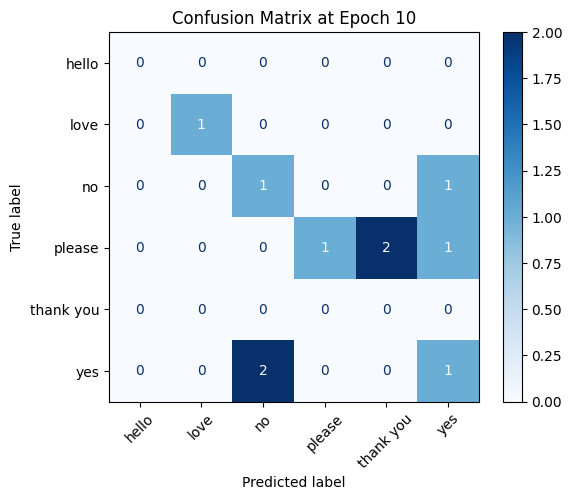

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.7563 - loss: 0.6848 - val_accuracy: 0.4000 - val_loss: 1.6626
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8849 - loss: 0.6312 - val_accuracy: 0.4000 - val_loss: 1.4008
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8189 - loss: 0.7473 - val_accuracy: 0.5000 - val_loss: 1.3962
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9179 - loss: 0.6793 - val_accuracy: 0.5000 - val_loss: 1.5260
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8656 - loss: 0.6801 - val_accuracy: 0.5000 - val_loss: 1.5249
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8205 - loss: 0.6793 - val_accuracy: 0.5000 - val_loss: 1.4638


ValueError: The filename must end in `.weights.h5`. Received: filepath=gesture_model_weights

In [8]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Load Data ===
df = pd.read_csv("/kaggle/working/basic_gesture_dualhand.csv")
grouped = df.groupby("video_id")
X, y = [], []

for video_id, group in grouped:
    group = group.sort_values("frame_id")
    features = group.iloc[:, 3:].values
    features = np.pad(features, ((0, 60 - len(features)), (0, 0)), mode='constant') if len(features) < 60 else features[:60]
    X.append(features)
    y.append(group["label"].values[0])

X = np.array(X)
y = np.array(y)

# === Label Encoding ===
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = tf.keras.utils.to_categorical(y_encoded)

# === Class Weights ===
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(enumerate(class_weights))

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# === Temporal Positional Encoding ===
class TemporalPositionalEncoding(tf.keras.layers.Layer):
    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        d_model = inputs.shape[-1]  # Use static shape if available

        position = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)
        div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(np.log(10000.0) / d_model))

        # Repeat position * div_term for the batch dimension
        sin_vals = tf.sin(position * div_term)
        cos_vals = tf.cos(position * div_term)

        # Interleave sin and cos
        pe = tf.concat([sin_vals, cos_vals], axis=-1)
        pe = pe[tf.newaxis, :, :]  # Shape: (1, seq_len, d_model)

        return inputs + pe


# === Attention Block ===
def spatial_temporal_attention(inputs):
    x = tf.keras.layers.LayerNormalization()(inputs)
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = tf.keras.layers.Add()([x, attn_output])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

# === Model Definition ===
def build_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = TemporalPositionalEncoding()(inputs)
    x = spatial_temporal_attention(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model = build_model((60, 126), num_classes=y_cat.shape[1])

# === Load Weights If Exists ===
import os
if os.path.exists("/kaggle/input/gesture-detection/gesture_model_weights.weights.h5"):
    print("🔁 Loading existing model weights...")
    model.load_weights("/kaggle/input/gesture-detection/gesture_model_weights.weights.h5")

# === Compile ===
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

# === EarlyStopping ===
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# === Confusion Matrix Callback (with fixed labels) ===
class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            preds = model.predict(X_test)
            y_true = np.argmax(y_test, axis=1)
            y_pred = np.argmax(preds, axis=1)

            # Fix: Ensure confusion matrix has the correct shape using labels explicitly
            cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(le.classes_)))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
            disp.plot(cmap="Blues", xticks_rotation=45)
            plt.title(f"Confusion Matrix at Epoch {epoch + 1}")
            plt.show()


# === Train ===
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    class_weight=class_weights,
    callbacks=[early_stop, ConfusionMatrixCallback()],
    verbose=1
)

# === Save Model Weights + LabelEncoder ===
model.save("/kaggle/working/gesture_model.keras")
 # This saves in TensorFlow's native format
with open("/kaggle/working/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


In [35]:
# === Save Model Weights + LabelEncoder ===
model.save_weights("/kaggle/working/gesture_model_weights.weights_.h5")
with open("/kaggle/working/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


In [25]:
from collections import Counter
print(Counter(y))

Counter({'yes': 12, 'no': 11, 'love': 7, 'please': 7, 'thank you': 7, 'hello': 4})


In [12]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# === Load Data ===
df = pd.read_csv("/kaggle/working/basic_gesture_dualhand.csv")
grouped = df.groupby("video_id")
X, y = [], []

for video_id, group in grouped:
    group = group.sort_values("frame_id")
    features = group.iloc[:, 3:].values
    # Pad or truncate to 60 frames
    features = np.pad(features, ((0, 60 - len(features)), (0, 0)), mode='constant') if len(features) < 60 else features[:60]
    X.append(features)
    y.append(group["label"].values[0])

X = np.array(X)
y = np.array(y)

# === Label Encoding ===
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = tf.keras.utils.to_categorical(y_encoded)

# === Class Weights ===
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(enumerate(class_weights))

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# === Temporal Positional Encoding ===
class TemporalPositionalEncoding(tf.keras.layers.Layer):
    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        d_model = inputs.shape[-1]  # Use static shape if available

        position = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)
        div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(np.log(10000.0) / d_model))

        sin_vals = tf.sin(position * div_term)
        cos_vals = tf.cos(position * div_term)

        # Interleave sin and cos and add batch dimension
        pe = tf.concat([sin_vals, cos_vals], axis=-1)
        pe = pe[tf.newaxis, :, :]  # Shape: (1, seq_len, d_model)
        return inputs + pe

# === Attention Block ===
def spatial_temporal_attention(inputs):
    x = tf.keras.layers.LayerNormalization()(inputs)
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = tf.keras.layers.Add()([x, attn_output])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

# === Model Definition ===
def build_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = TemporalPositionalEncoding()(inputs)
    x = spatial_temporal_attention(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

# === Triplet Model Creation ===
def create_embedding_model(input_shape):
    input_layer = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(input_layer)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    embeddings = tf.keras.layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(x)
    model = tf.keras.Model(inputs=input_layer, outputs=embeddings)
    return model

def triplet_loss(alpha=0.2):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, :128], y_pred[:, 128:256], y_pred[:, 256:]
        positive_distance = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        negative_distance = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        loss = tf.maximum(positive_distance - negative_distance + alpha, 0.0)
        return tf.reduce_mean(loss)
    return loss

def create_triplet_model(input_shape):
    embedding_model = create_embedding_model(input_shape)
    anchor_input = tf.keras.Input(shape=input_shape)
    positive_input = tf.keras.Input(shape=input_shape)
    negative_input = tf.keras.Input(shape=input_shape)
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)
    concatenated_embeddings = tf.keras.layers.concatenate(
        [anchor_embedding, positive_embedding, negative_embedding], axis=-1
    )
    model = tf.keras.Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=concatenated_embeddings
    )
    model.compile(optimizer='adam', loss=triplet_loss(alpha=0.2))
    return model

def create_triplet_pairs(X, y, num_classes):
    triplets = []
    for i in range(len(X)):
        anchor = X[i]
        anchor_class = y[i]
        # Find a positive sample (same class)
        positive_indices = np.where(y == anchor_class)[0]
        positive_idx = np.random.choice(positive_indices)
        positive = X[positive_idx]
        # Find a negative sample (different class)
        negative_class = np.random.choice(np.delete(np.arange(num_classes), anchor_class))
        negative_indices = np.where(y == negative_class)[0]
        if len(negative_indices) > 0:
            negative_idx = np.random.choice(negative_indices)
            negative = X[negative_idx]
            triplets.append([anchor, positive, negative])
        else:
            continue  # Skip if no negative sample is found
    return np.array(triplets)

# === Create Triplets from the Training Data ===
# Note: Using np.argmax to convert one-hot y_train to integer labels
triplets_train = create_triplet_pairs(X_train, np.argmax(y_train, axis=1), len(le.classes_))

# === Train the Triplet Model ===
triplet_model = create_triplet_model(input_shape=(60, 126))
triplet_model.fit(
    [triplets_train[:, 0], triplets_train[:, 1], triplets_train[:, 2]],
    np.zeros(len(triplets_train)),  # Dummy labels for triplet loss
    epochs=50,
    batch_size=8,
    verbose=1
)

# === Save Model Weights + LabelEncoder ===
triplet_model.save_weights("/kaggle/working/similarity.weights.h5")
with open("/kaggle/working/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.2786
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1387
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1141
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0991
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0612
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0538
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0327
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0353
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0095
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0318
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0175
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0187
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0132
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0058
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0058
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━

In [1]:
!ls /kaggle/working

In [4]:
#cloning the repository
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

token = user_secrets.get_secret("PAT")

!git clone https://{token}@github.com/atchudhansg/sign-language-data-prep.git

Cloning into 'sign-language-data-prep'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 120 (delta 47), reused 80 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (120/120), 14.15 MiB | 19.29 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [5]:
from kaggle_secrets import UserSecretsClient
import os

# === Safe working directory ===
%cd /kaggle/working

# === Git & Kaggle Auth ===
!git config --global user.name "atchudhansg"
!git config --global user.email "116624804+atchudhansg@users.noreply.github.com"

user_secrets = UserSecretsClient()
kaggle_username = user_secrets.get_secret("KAGGLE_USERNAME")
kaggle_key = user_secrets.get_secret("KAGGLE_KEY")
github_token = user_secrets.get_secret("PAT")

os.environ["KAGGLE_USERNAME"] = kaggle_username
os.environ["KAGGLE_KEY"] = kaggle_key

#check if the notebook is downloaded or not
!ls /kaggle/working

#download the notebook in working directory
!kaggle kernels pull atchusg/machine-vision-gesture-detection -p /kaggle/working

#check if the notebook is downloaded or not
!ls /kaggle/working

!mkdir -p /kaggle/working/sign-language-data-prep/notebooks/kaggle
!mv /kaggle/working/machine-vision-gesture-detection.ipynb /kaggle/working/sign-language-data-prep/notebooks/kaggle/
%cd /kaggle/working/sign-language-data-prep

#commit the stages
!git add .
!git commit -m "Update Kaggle Notebook"

#push to github
token = user_secrets.get_secret("PAT")
!git push https://{token}@github.com/atchudhansg/sign-language-data-prep.git main

/kaggle/working
sign-language-data-prep
Source code downloaded to /kaggle/working/machine-vision-gesture-detection.ipynb
machine-vision-gesture-detection.ipynb	sign-language-data-prep
/kaggle/working/sign-language-data-prep
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


In [6]:
!kaggle kernels pull atchusg/machine-vision-gesture-detection -p /kaggle/working

Source code downloaded to /kaggle/working/machine-vision-gesture-detection.ipynb


In [7]:
#check if the notebook is downloaded or not
!ls /kaggle/working

!mkdir -p /kaggle/working/sign-language-data-prep/notebooks/kaggle
!mv /kaggle/working/machine-vision-gesture-detection.ipynb /kaggle/working/sign-language-data-prep/notebooks/kaggle/
%cd /kaggle/working/sign-language-data-prep

machine-vision-gesture-detection.ipynb	sign-language-data-prep
/kaggle/working/sign-language-data-prep


In [8]:
#commit the stages
!git add .
!git commit -m "Fresh training with WLASL 2000 dataset"

#push to github
token = user_secrets.get_secret("PAT")
!git push https://{token}@github.com/atchudhansg/sign-language-data-prep.git main

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date
